In [2]:
from meta_ai_api import MetaAI
import matplotlib.pyplot as plt
import tqdm
import random
import time
import multiprocessing
from multiprocessing import Pool
import numpy as np
import pandas as pd
import json
import os
import replicate
import glob
import matplotlib.pyplot as plt
from collections import Counter

In [9]:
token = open('token.txt').read().strip()
os.environ['REPLICATE_API_TOKEN'] = token

In [4]:
# # The meta/meta-llama-3-70b-instruct model can stream output as it's running.
# for event in replicate.stream(
#     "meta/meta-llama-3-70b-instruct",
#     input={
#         "top_k": 0,
#         "top_p": 0.9,
#         "prompt": "Can you tell me which model version you are and how many parameters you have?",
#         "max_tokens": 512,
#         "min_tokens": 0,
#         "temperature": 0.6,
#         "system_prompt": "You are a helpful assistant",
#         "length_penalty": 1,
#         "stop_sequences": "<|end_of_text|>,<|eot_id|>",
#         "prompt_template": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful assistant<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
#         "presence_penalty": 1.15,
#         "log_performance_metrics": False
#     },
# ):
#     print(str(event), end="")

In [5]:
# ai = MetaAI()
# response = ai.prompt(message="Can you tell me which version of model you are? Also, how many parameters do you have?")
# print(response)

In [3]:
def query_ai_MetaAPI(expression):
    ai = MetaAI()
    message = f"Evaluate the following arithmetic expression and output the final answer as a single number. Do not show your work. Do not include any extra text. \n\n {expression} = ?"
    response = ai.prompt(message=message)
    return int(response['message'])

def query_ai_replicate(expression):
    # The meta/meta-llama-3-70b-instruct model can stream output as it's running.
    response = []
    for event in replicate.stream(
        "meta/meta-llama-3-70b-instruct",
        input={
            "top_k": 0,
            "top_p": 0.9,
            # "prompt": f"Evaluate the expression and output the answer as a single number. Do not show your work. Do not include any extra text. '%' is the modulo operator. \n\n {expression} = ?",
            "prompt": f"Evaluate the expression and output the answer as a single number. Do not show your work. Do not include any extra text. \n\n {expression} = ?",
            "max_tokens": 512,
            "min_tokens": 0,
            "temperature": 0.6,
            "system_prompt": "You are a helpful assistant",
            "length_penalty": 1,
            "stop_sequences": "<|end_of_text|>,<|eot_id|>",
            "prompt_template": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful assistant<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
            "presence_penalty": 1.15,
            "log_performance_metrics": False
        },
    ):
        response.append(str(event))
    return int(''.join(response).replace(',', ''))

def ask_ensemble(n,expression):
    responses = []
    # progress_bar = tqdm.tqdm(total=n)
    count = 0
    while len(responses) < n:
        try:
            responses.append(query_ai_replicate(expression))
            # progress_bar.update(1)
        except:
            time.sleep(1)
            pass
    return responses

def generate_ooo_expression(n_ops, max_int=9):
    """
    Recursively generates a mathematical expression with the specified number of operations.

    Parameters:
    n_ops (int): The number of operations (+, -, *) to include in the expression.
    n_ops (list): The number of operations (+, -, *) to include in the expression (randomly chosen from the list).

    Returns:
    str: A string representing the generated mathematical expression.
    """
    
    if type(n_ops) == list:
        n_ops = random.choice(n_ops)
    
    if n_ops == 0:
        # Base case: return a random positive integer between 1 and 9
        return str(random.randint(1, max_int))
    else:
        # Randomly split the remaining operations between left and right sub-expressions
        n_ops_left = random.randint(0, n_ops - 1)
        n_ops_right = n_ops - 1 - n_ops_left

        # Recursively generate left and right sub-expressions
        left_expr = generate_ooo_expression(n_ops_left, max_int)
        right_expr = generate_ooo_expression(n_ops_right, max_int)

        # Randomly choose an operator
        # op = random.choice(['+', '-', '*', '%'])
        op = random.choice(['+', '-', '*'])

        # Combine the expressions with the operator
        expr = f'{left_expr}{op}{right_expr}'

        # Randomly decide whether to wrap the expression in parentheses
        if random.choice([True, False]):
            expr = f'({expr})'
        return expr
    
def generate_multiplication_expression(out_digits=7):
    if type(out_digits) == list:
        out_digits = random.choice(out_digits)
    
    while True:
        middle_out_digits = random.choice(list(range(1, out_digits//2+1)))
        a = random.randint(10**(middle_out_digits - 1), 10**middle_out_digits - 1)
        b = random.randint(10**((out_digits - middle_out_digits) - 1), 10**(out_digits - middle_out_digits) - 1)
        if len(str(a*b)) == out_digits:
            break
    if random.choice([True, False]):
        expr = f'{b}*{a}'
    else:
        expr = f'{a}*{b}'
    return expr

# def generate_series_expression(terms = 6, complexity = 1):
#     # https://pmc.ncbi.nlm.nih.gov/articles/PMC6491774/
#     # ['a_n = a_{n-1} + k', 'a_n = a_{n-1} * k', 'a_n = a_{n-1} + a_{n-2}', 'a_n = a_{n-1} * a_{n-2}']
#     # 1:arithmetic, 2:geometric, 3:addition, 4:multiplication

#     first_term = random.choice([0,1,2,3,4,5])
#     k = random.choice([1,2,3,4,5])

#     rule = random.choice([1,2,3,4])
#     series = [0,first_term]
#     for i in range(terms+1):
#         if rule == 1:
#             series.append(series[-1] + k)
#         elif rule == 2:
#             series.append(series[-1] * k)
#         elif rule == 3:
#             series.append(series[-1] + series[-2])
#         elif rule == 4:
#             series.append(series[-1] * series[-2])
    
#     # if complexity > 1:
#     #     rule = random.choice([1,2])
#     #     prev_series = series
#     #     series = [prev_series[1]]
#     #     for i in range(terms+1):
#     #         if rule == 1:
#     #             series.append(series[-1] + prev_series[i])
#     #         elif rule == 2:
#     #             series.append(series[-1] * prev_series[i])
    
#     series = series[1:]
    
#     expr = f''
#     for s in series[:-1]:
#         expr += f'{s}, '
#     expr = f'{expr}?'
#     return expr, series[-1]
    
def generate_and_evaluate(n_agents, n_ops, max_int, savedir=None):
    expression = generate_ooo_expression(n_ops, max_int)
    # expression = generate_multiplication_expression(max_int)
    responses = ask_ensemble(n_agents,expression)
    print(f'finished expression {expression}')
    if savedir is not None:
        with open(f'{savedir}/{expression}.json', "w") as outfile:
            json.dump({'expression':expression,
                       'responses':responses,
                       'n_agents':n_agents,
                       'n_ops':n_ops,
                       'max_int':max_int,
                       'correct':eval(expression),}, 
                      outfile, indent=4)
    return expression, responses
    
    
def take_exam(n_questions, n_agents, n_ops, max_int, savedir=None):
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    with Pool(8) as p:
        results = p.starmap(generate_and_evaluate, [(n_agents, n_ops, max_int, savedir) for _ in range(n_questions)])
    return results

def calc_mode(responses):
    mode = []
    max_count = responses.count(responses[0])
    for response in set(responses):
        if responses.count(response) > max_count:
            mode = [response]
            max_count = responses.count(response)
        elif responses.count(response) == max_count:
            mode.append(response)
    return mode, max_count

def vote(responses, threshold, correct):
    mode, count = calc_mode(responses)
    if len(mode) > 1:
        return 0
    elif count/len(responses) < threshold:
        return 0
    elif mode[0] == correct:
        return 1
    else:
        return -1

def vote_count(responses):
    return [int(np.sum(np.array(responses) == i)) for i in [-1, 0, 1]]

def calc_entropy(responses):
    entropy = []
    for response in responses:
        counts = np.array([response.count(i) for i in set(response)])
        probs = counts/np.sum(counts)
        entropy.append(-np.sum(probs*np.log(probs)))
    return entropy

In [147]:
expression = generate_multiplication_expression([2,5])
response = query_ai_replicate(expression)
print(f'Expression: {expression}     Response: {response}     Answer: {eval(expression)}')

Expression: 8*5     Response: 40     Answer: 40


In [150]:
expression = generate_ooo_expression(n_ops=1, max_int=9)
response = query_ai_replicate(expression)
print(f'Expression: {expression}     Response: {response}     Answer: {eval(expression)}')

Expression: (7*3)     Response: 21     Answer: 21


In [152]:
# results = take_exam(n_questions=500, n_agents=25, n_ops=[1,2,3], max_int=99, savedir=f'math_outputs/test1_500questions_25agents_1-2-3ops_99maxint_nomodulo')
# results = take_exam(n_questions=500, n_agents=25, n_ops=1, max_int=[3,4,5,6,7], savedir=f'math_outputs/test1_500questions_25agents_multiplication_3-7digits')

In [4]:
# Open ensemble results
questions = []
responses = []
answers = []
n_ops = []
n_agents = []
max_int = []

for file in tqdm.tqdm(glob.glob('/home/trevor/repos/LLM_ensembling/maths/math_outputs/test1_500questions_25agents_multiplication_3-7digits/*.json')):
# for file in tqdm.tqdm(glob.glob('/home/trevor/repos/LLM_ensembling/maths/math_outputs/test1_500questions_25agents_1-2-3ops_99maxint_nomodulo/*.json')):
# for file in tqdm.tqdm(glob.glob('/home/trevor/repos/LLM_ensembling/maths/math_outputs/test1_500questions_25agents_1-2-3-4-5-6ops_9maxint_nomodulo/*.json')):
# for file in tqdm.tqdm(glob.glob('/home/trevor/repos/LLM_ensembling/maths/math_outputs/test1_200questions_25agents_4-5-6ops_4maxint_nomodulo/*.json')):
# for file in tqdm.tqdm(glob.glob('/home/strevor/repos/LLM_ensembling/maths/math_outputs/test1_200questions_25agents_2-3-4ops_9maxint_nomodulo/*.json')):
# for file in tqdm.tqdm(glob.glob('/home/trevor/repos/LLM_ensembling/maths/math_outputs/test1_200questions_25agents_2-3-4ops_9maxint/*.json')):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            questions.append(data['expression'])
            responses.append(data['responses'])
            answers.append(data['correct'])
            n_ops.append(data['n_ops'])
            n_agents.append(data['n_agents'])
            max_int.append(data['max_int'])
    except:
        print(file)
        os.remove(file)

100%|██████████| 500/500 [00:00<00:00, 9884.63it/s]


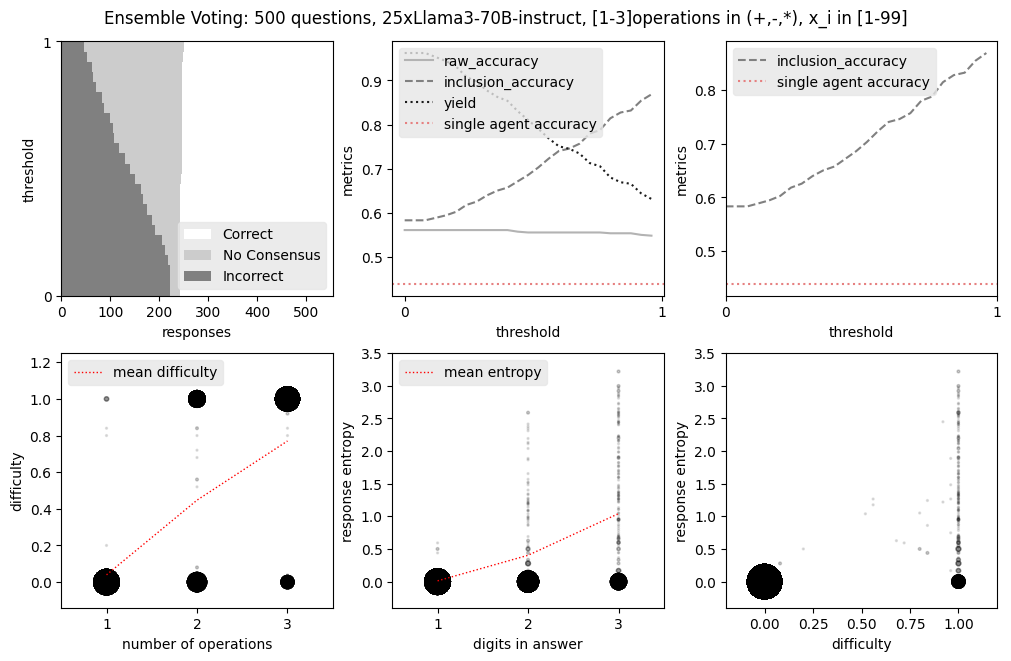

In [19]:
thresholds = 25
running_vals = [[vote_count([vote(responses[i], thresh, answers[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, 25)]]

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(2,3, figsize=(10,6.5), constrained_layout=True)

ax[0,0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0,0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0,0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0,0].set_ylim([0, thresholds])
ax[0,0].set_xlim([0, len(questions)])
ax[0,0].set_yticks([0, thresholds])
ax[0,0].set_yticklabels(['0', '1'])
ax[0,0].set_ylabel('threshold')
ax[0,0].set_xlabel('responses')
ax[0,0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[0,1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[0,1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[0,1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[0,1].set_ylabel('metrics')
ax[0,1].set_xlabel('threshold')
ax[0,1].set_xticks([0, thresholds])
ax[0,1].set_xticklabels(['0', '1'])
ax[0,1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[0,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[0,2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[0,2].set_ylabel('metrics')
# ax[2].set_ylim([0.6, 1.05])
ax[0,2].set_xlabel('threshold')
ax[0,2].set_xlim([0, thresholds])
ax[0,2].set_xticks([0, thresholds])
ax[0,2].set_xticklabels(['0', '1'])
ax[0,2].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[0,2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ops = [sum([1 for ch in question if ch in ['+', '-', '*']]) for question in questions]
c = Counter(zip(ops,difficulty))
s = [2*(c[(xx,yy)]) for xx,yy in zip(ops,difficulty)]
ax[1,0].scatter(np.array(ops), 
              np.array(difficulty), 
              s=s, c='k', alpha=0.1)
# ax[1,0].scatter(n_ops[0], 
#               [float(np.mean(np.array(difficulty)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
#               s=5, c='r', alpha=1, label='question difficulty')
ax[1,0].plot(n_ops[0],[float(np.mean(np.array(difficulty)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean difficulty')
ax[1,0].set_xlabel('number of operations')
ax[1,0].set_ylabel('difficulty')
ax[1,0].set_xticks(n_ops[0])
ax[1,0].set_xlim([0.5, 3.5])
ax[1,0].set_ylim([-0.14, 1.25])
ax[1,0].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# uncertainty = [len(set(response)) for response in responses]
entropy = calc_entropy(responses)

# ax[1,1].scatter(np.array(ops) + np.random.randn(len(ops))*0.05, 
#               np.array(uncertainty), 
#               s=5, c='k', alpha=0.1)
# # ax[1,1].scatter(n_ops[0], 
# #               [float(np.mean(np.array(uncertainty)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
# #               s=5, c='r', alpha=1, label='question difficulty')
# ax[1,1].plot(n_ops[0],[float(np.mean(np.array(uncertainty)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
#              c='r', alpha=1, linewidth=1, linestyle=':', label='mean unique responses')
# ax[1,1].set_xlabel('number of operations')
# ax[1,1].set_ylabel('unique responses')
# ax[1,1].set_xticks(n_ops[0])
# ax[1,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ops = [sum([1 for ch in question if ch in ['+', '-', '*']]) for question in questions]
# ax[1,2].scatter(np.array(ops) + np.random.randn(len(ops))*0.05, 
#               np.array(entropy), 
#               s=5, c='k', alpha=0.1)
# # ax[1,2].scatter(n_ops[0], 
# #               [float(np.mean(np.array(entropy)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
# #               s=5, c='r', alpha=1, label='question difficulty')
# ax[1,2].plot(n_ops[0],[float(np.mean(np.array(entropy)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
#              c='r', alpha=1, linewidth=1, linestyle=':', label='mean entropy')
# ax[1,2].set_xlabel('number of operations')
# ax[1,2].set_ylabel('response entropy')
# ax[1,2].set_xticks(n_ops[0])
# ax[1,2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ops = [sum([1 for ch in question if ch in ['+', '-', '*']]) for question in questions]
c = Counter(zip(ops,entropy))
s = [2*(c[(xx,yy)]) for xx,yy in zip(ops,entropy)]
ax[1,1].scatter(np.array(ops), 
              np.array(entropy), 
              s=s, c='k', alpha=0.1)
ax[1,1].plot(n_ops[0],[float(np.mean(np.array(entropy)[np.where(np.array(ops) == n_op)[0]])) for n_op in n_ops[0]], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean entropy')
ax[1,1].set_xlabel('number of operations')
ax[1,1].set_ylabel('response entropy')
ax[1,1].set_xticks(n_ops[0])
ax[1,1].set_xlim([0.5, 3.5])
ax[1,1].set_ylim([-0.4, 3.5])
ax[1,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

c = Counter(zip(difficulty,entropy))
s = [2*(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[1,2].scatter(difficulty, entropy, s=s, c='k', alpha=0.1)
ax[1,2].set_xlim([-0.2, 1.2])
ax[1,2].set_ylim([-0.4, 3.5])
ax[1,2].set_xlabel('difficulty')
ax[1,2].set_ylabel('response entropy')

plt.suptitle(f'Ensemble Voting: {500} questions, {25}xLlama3-70B-instruct, [1-3]operations in (+,-,*), x_i in [1-99]', fontsize=12)
plt.savefig(f'EnsembleVoting_q{500}_a{25}_1-3ops_1-99ints.png', format='png', dpi=300)

# plt.suptitle(f'Ensemble Voting: {500} questions, {25}xLlama3-70B-instruct, [1-6]operations in (+,-,*), x_i in [1-9]', fontsize=12)
# plt.savefig(f'EnsembleVoting_q{500}_a{25}_1-6ops_1-9ints.png', format='png', dpi=300)

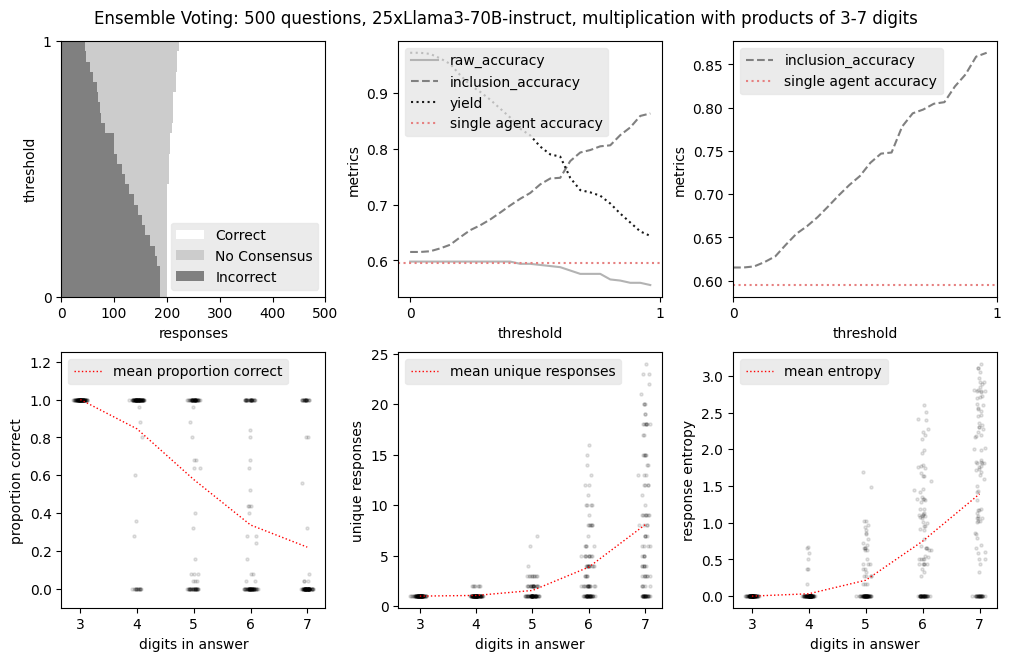

In [28]:
thresholds = 25
running_vals = [[vote_count([vote(responses[i], thresh, answers[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, 25)]]

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

proportion_correct = []
for i in range(len(responses)):
    proportion_correct.append(np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = float(np.mean(np.array(proportion_correct)))


fig, ax = plt.subplots(2,3, figsize=(10,6.5), constrained_layout=True)

ax[0,0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0,0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0,0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0,0].set_ylim([0, thresholds])
ax[0,0].set_xlim([0, len(questions)])
ax[0,0].set_yticks([0, thresholds])
ax[0,0].set_yticklabels(['0', '1'])
ax[0,0].set_ylabel('threshold')
ax[0,0].set_xlabel('responses')
ax[0,0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[0,1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[0,1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[0,1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[0,1].set_ylabel('metrics')
ax[0,1].set_xlabel('threshold')
ax[0,1].set_xticks([0, thresholds])
ax[0,1].set_xticklabels(['0', '1'])
ax[0,1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[0,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[0,2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[0,2].set_ylabel('metrics')
# ax[2].set_ylim([0.6, 1.05])
ax[0,2].set_xlabel('threshold')
ax[0,2].set_xlim([0, thresholds])
ax[0,2].set_xticks([0, thresholds])
ax[0,2].set_xticklabels(['0', '1'])
ax[0,2].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[0,2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

digits = [len(str(answer)) for answer in answers]
n_digits = list(set(digits))
ax[1,0].scatter(np.array(digits) + np.random.randn(len(digits))*0.05, 
              np.array(proportion_correct), 
              s=5, c='k', alpha=0.1)
ax[1,0].plot(n_digits,[float(np.mean(np.array(proportion_correct)[np.where(np.array(digits) == n_d)[0]])) for n_d in n_digits], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean proportion correct')
ax[1,0].set_xlabel('digits in answer')
ax[1,0].set_ylabel('proportion correct')
ax[1,0].set_xticks(n_digits)
ax[1,0].set_ylim([-0.1, 1.25])
ax[1,0].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

uncertainty = [len(set(response)) for response in responses]
entropy = calc_entropy(responses)

ax[1,1].scatter(np.array(digits) + np.random.randn(len(digits))*0.05, 
              np.array(uncertainty), 
              s=5, c='k', alpha=0.1)
ax[1,1].plot(n_digits,[float(np.mean(np.array(uncertainty)[np.where(np.array(digits) == n_op)[0]])) for n_op in n_digits], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean unique responses')
ax[1,1].set_xlabel('digits in answer')
ax[1,1].set_ylabel('unique responses')
ax[1,1].set_xticks(n_digits)
ax[1,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1,2].scatter(np.array(digits) + np.random.randn(len(digits))*0.05, 
              np.array(entropy), 
              s=5, c='k', alpha=0.1)
ax[1,2].plot(n_digits,[float(np.mean(np.array(entropy)[np.where(np.array(digits) == n_op)[0]])) for n_op in n_digits], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean entropy')
ax[1,2].set_xlabel('digits in answer')
ax[1,2].set_ylabel('response entropy')
ax[1,2].set_xticks(n_digits)
ax[1,2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

plt.suptitle(f'Ensemble Voting: {500} questions, {25}xLlama3-70B-instruct, multiplication with products of 3-7 digits', fontsize=12)
plt.savefig(f'EnsembleVoting_q{500}_a{25}_multiplication_3-7digits.png', format='png', dpi=300)

In [43]:
def generate_series_expression(terms = 6, complexity = 1):
    # https://pmc.ncbi.nlm.nih.gov/articles/PMC6491774/
    # ['a_n = a_{n-1} + k', 'a_n = a_{n-1} * k', 'a_n = a_{n-1} + a_{n-2}', 'a_n = a_{n-1} * a_{n-2}']
    # 1:arithmetic, 2:geometric, 3:addition, 4:multiplication

    zeroth_term = 0
    first_term = random.choice([0,1,2,3,4,5])
    k = random.choice([1,2,3,4,5])

    serieses = []
    for i in range(complexity):
        rule = random.choice([1,2,3,4])
        series = [zeroth_term,first_term]
        print(f'rule: {rule}')
        for i in range(terms+1):
            if rule == 1:
                series.append(series[-1] + k)
            elif rule == 2:
                series.append(series[-1] * k)
            elif rule == 3:
                series.append(series[-1] + series[-2])
            elif rule == 4:
                series.append(series[-1] * series[-2])
        serieses.append(series)
    
    serieses = list(np.sum(np.array(serieses), axis=0))[2:]
    expr = f''
    for s in serieses[:-1]:
        expr += f'{s}, '
    expr = f'{expr}?'
    return expr, int(serieses[-1])

In [52]:
generate_series_expression(5,2)

rule: 3
rule: 3


('10, 20, 30, 50, 80, ?', 130)

Text(0, 0.5, 'response entropy')

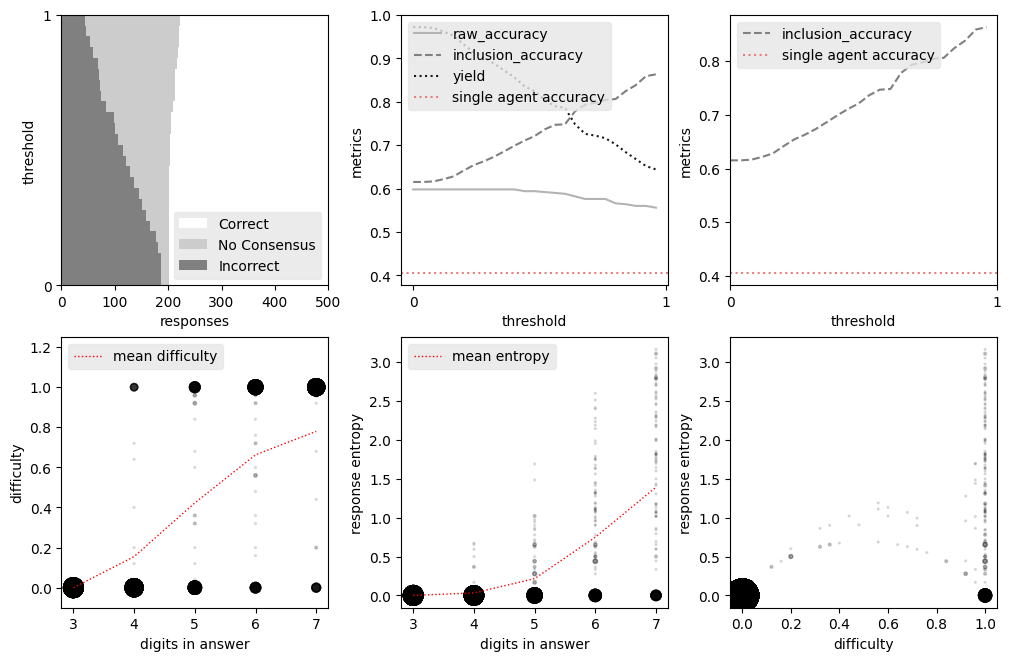

In [6]:
thresholds = 25
running_vals = [[vote_count([vote(responses[i], thresh, answers[i]) for i in range(len(responses))]) for thresh in np.linspace(0, 1, 25)]]

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

difficulty = []
for i in range(len(responses)):
    difficulty.append(1-np.sum(np.array(responses[i]) == answers[i])/len(responses[i]))
single_model_acc = float(np.mean(np.array(difficulty)))


fig, ax = plt.subplots(2,3, figsize=(10,6.5), constrained_layout=True)

ax[0,0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0,0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0,0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0,0].set_ylim([0, thresholds])
ax[0,0].set_xlim([0, len(questions)])
ax[0,0].set_yticks([0, thresholds])
ax[0,0].set_yticklabels(['0', '1'])
ax[0,0].set_ylabel('threshold')
ax[0,0].set_xlabel('responses')
ax[0,0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[0,1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[0,1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[0,1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[0,1].set_ylabel('metrics')
ax[0,1].set_xlabel('threshold')
ax[0,1].set_xticks([0, thresholds])
ax[0,1].set_xticklabels(['0', '1'])
ax[0,1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[0,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[0,2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[0,2].set_ylabel('metrics')
# ax[2].set_ylim([0.6, 1.05])
ax[0,2].set_xlabel('threshold')
ax[0,2].set_xlim([0, thresholds])
ax[0,2].set_xticks([0, thresholds])
ax[0,2].set_xticklabels(['0', '1'])
ax[0,2].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[0,2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

digits = [len(str(answer)) for answer in answers]
n_digits = list(set(digits))
c = Counter(zip(digits,difficulty))
s = [2*(c[(xx,yy)]) for xx,yy in zip(digits,difficulty)]
ax[1,0].scatter(np.array(digits), 
              np.array(difficulty), 
              s=s, c='k', alpha=0.1)
ax[1,0].plot(n_digits,[float(np.mean(np.array(difficulty)[np.where(np.array(digits) == n_d)[0]])) for n_d in n_digits], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean difficulty')
ax[1,0].set_xlabel('digits in answer')
ax[1,0].set_ylabel('difficulty')
ax[1,0].set_xticks(n_digits)
ax[1,0].set_ylim([-0.1, 1.25])
ax[1,0].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

uncertainty = [len(set(response)) for response in responses]
entropy = calc_entropy(responses)

# ax[1,1].scatter(np.array(digits) + np.random.randn(len(digits))*0.05, 
#               np.array(uncertainty), 
#               s=5, c='k', alpha=0.1)
# ax[1,1].plot(n_digits,[float(np.mean(np.array(uncertainty)[np.where(np.array(digits) == n_op)[0]])) for n_op in n_digits], 
#              c='r', alpha=1, linewidth=1, linestyle=':', label='mean unique responses')
# ax[1,1].set_xlabel('digits in answer')
# ax[1,1].set_ylabel('unique responses')
# ax[1,1].set_xticks(n_digits)
# ax[1,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

c = Counter(zip(digits,entropy))
s = [2*(c[(xx,yy)]) for xx,yy in zip(digits,entropy)]
ax[1,1].scatter(np.array(digits), 
              np.array(entropy), 
              s=s, c='k', alpha=0.1)
ax[1,1].plot(n_digits,[float(np.mean(np.array(entropy)[np.where(np.array(digits) == n_op)[0]])) for n_op in n_digits], 
             c='r', alpha=1, linewidth=1, linestyle=':', label='mean entropy')
ax[1,1].set_xlabel('digits in answer')
ax[1,1].set_ylabel('response entropy')
ax[1,1].set_xticks(n_digits)
ax[1,1].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

c = Counter(zip(difficulty,entropy))
s = [2*(c[(xx,yy)]) for xx,yy in zip(difficulty,entropy)]
ax[1,2].scatter(difficulty, entropy, s=s, c='k', alpha=0.1)
# ax[1,2].plot(n_digits,[float(np.mean(np.array(uncertainty)[np.where(np.array(digits) == n_op)[0]])) for n_op in n_digits], 
#              c='r', alpha=1, linewidth=1, linestyle=':', label='mean unique responses')
ax[1,2].set_xlabel('difficulty')
ax[1,2].set_ylabel('response entropy')

# a,b = np.polyfit(entropy, difficulty, 1)
# x = np.linspace(0, 1, 100)
# ax[1,2].plot(x, a*x + b, color='r', linestyle=':', label='linear fit')
# ax[1,2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# plt.suptitle(f'Ensemble Voting: {500} questions, {25}xLlama3-70B-instruct, multiplication with products of 3-7 digits', fontsize=12)
# plt.savefig(f'EnsembleVoting_q{500}_a{25}_multiplication_3-7digits.png', format='png', dpi=300)

In [22]:
import numpy as np
import statsmodels.api as sm

# Sample data
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 5, 4, 5])

# Add a constant to the independent variable for the intercept
x = sm.add_constant(x)

# Fit the model
model = sm.OLS(y, x).fit()

# Get the regression coefficients
coefficients = model.params

# Get the confidence intervals
conf_int = model.conf_int(alpha=0.05)  # 95% confidence interval

print("Coefficients:", coefficients)
print("Confidence Intervals:")
print(conf_int)

Coefficients: [2.2 0.6]
Confidence Intervals:
[[-0.78539926  5.18539926]
 [-0.30013175  1.50013175]]


In [24]:
coefficients

array([2.2, 0.6])